# Simple Optimal Growth のコードを自分の線形補間関数を用いて書き直す

In [49]:
# Page: http://lectures.quantecon.org/jl/optgrowth.html
include("ex01.jl")
using Optim: optimize
using Plots
using Interact
pyplot()

Plots.PyPlotBackend()

## A First Pass Implementation


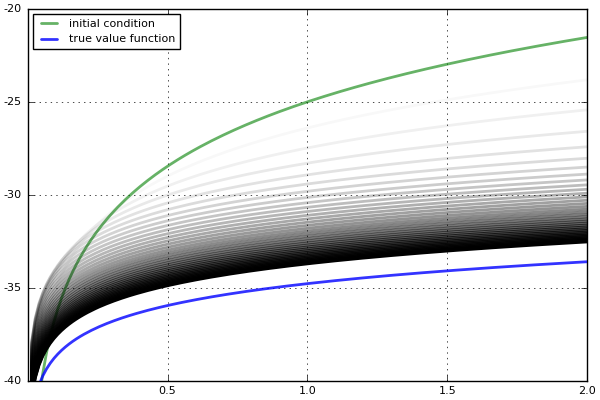

In [50]:
#=
A first pass at solving the optimal growth problem via value function
iteration.  A more general version is provided in optgrowth.py.

@author : Spencer Lyon <spencer.lyon@nyu.edu>
          Victoria Gregory <victoria.gregory@nyu.edu>
=#
    
## Primitives and grid
alpha = 0.65
bet = 0.95
grid_max = 2
grid_size = 150
grid = 1e-6:(grid_max-1e-6)/(grid_size-1):grid_max

## Exact solution
ab = alpha * bet
c1 = (log(1 - ab) + log(ab) * ab / (1 - ab)) / (1 - bet)
c2 = alpha / (1 - ab)
v_star_func(k) = c1 .+ c2 .* log(k)


function bellman_operator(grid, w)
    Aw = LinearInterpolation.LinInterp(grid, w)
    Tw = zeros(w)

    for (i, k) in enumerate(grid)
        objective(c) = - log(c) - bet * Aw(k^alpha - c)
        res = optimize(objective, 1e-6, k^alpha)
        Tw[i] = - objective(res.minimum)
    end
    return Tw
end

function main(n::Int=35)
    w_init = 5 .* log(grid) .- 25  # An initial condition -- fairly arbitrary
    w = copy(w_init)

    ws = []
    colors = []
    for i=1:n
        w = bellman_operator(grid, w)
        push!(ws, w)
        push!(colors, RGBA(0, 0, 0, i/n))
    end
    p = plot(grid, w_init, color=:green, linewidth=2, alpha=0.6, label="initial condition")
    plot!(grid, ws, color=colors', label="", linewidth=2)
    plot!(grid, v_star_func(grid), color=:blue, linewidth=2, alpha=0.8, label="true value function")
    plot!(ylims=(-40, -20), xlims=(minimum(grid), maximum(grid)))

    return p
end

main()

## Implementation 2

再利用可能な関数を書く

In [51]:
#=
Solving the optimal growth problem via value function iteration.

@author : Spencer Lyon <spencer.lyon@nyu.edu>

@date : 2014-07-05

References
----------

Simple port of the file quantecon.models.optgrowth

http://quant-econ.net/jl/dp_intro.html
=#

#=
    This type defines the primitives representing the growth model. The
    default values are

        f(k) = k**alpha, i.e, Cobb-Douglas production function
        u(c) = ln(c), i.e, log utility

    See the constructor below for details
=#
                
"""
Neoclassical growth model

##### Fields

- `f::Function` : Production function
- `bet::Real` : Discount factor in (0, 1)
- `u::Function` : Utility function
- `grid_max::Int` : Maximum for grid over savings values
- `grid_size::Int` : Number of points in grid for savings values
- `grid::LinSpace{Float64}` : The grid for savings values

"""
type GrowthModel
    f::Function
    beta::Float64
    u::Function
    grid_max::Int
    grid_size::Int
    grid::LinSpace{Float64}
end

default_f(k) = k^0.65
default_u(c) = log(c)

"""
Constructor of `GrowthModel`

##### Arguments

- `f::Function(k->k^0.65)` : Production function
- `bet::Real(0.95)` : Discount factor in (0, 1)
- `u::Function(log)` : Utility function
- `grid_max::Int(2)` : Maximum for grid over savings values
- `grid_size::Int(150)` : Number of points in grid for savings values

"""
function GrowthModel(f=default_f, beta=0.95, u=default_u, grid_max=2, grid_size=150)
    grid = linspace(1e-6, grid_max, grid_size)
    return GrowthModel(f, beta, u, grid_max, grid_size, grid)
end

"""
Apply the Bellman operator for a given model and initial value.

##### Arguments

- `g::GrowthModel` : Instance of `GrowthModel`
- `w::Vector`: Current guess for the value function
- `out::Vector` : Storage for output.
- `;ret_policy::Bool(false)`: Toggles return of value or policy functions

##### Returns

None, `out` is updated in place. If `ret_policy == true` out is filled with the
policy function, otherwise the value function is stored in `out`.

"""
function bellman_operator!(g::GrowthModel, w::Vector, out::Vector; ret_policy::Bool=false)
    # Apply linear interpolation to w
    Aw =  LinearInterpolation.LinInterp(g.grid, w)

    for (i, k) in enumerate(g.grid)
        objective(c) = - g.u(c) - g.beta * Aw(g.f(k) - c)
        res = optimize(objective, 1e-6, g.f(k))
        c_star = res.minimum

        if ret_policy
            # set the policy equal to the optimal c
            out[i] = c_star
        else
            # set Tw[i] equal to max_c { u(c) + beta w(f(k_i) - c)}
            out[i] = - objective(c_star)
        end
    end

    return out
end

function bellman_operator(g::GrowthModel, w::Vector; ret_policy::Bool=false)
    out = similar(w)
    bellman_operator!(g, w, out, ret_policy=ret_policy)
end

"""
Extract the greedy policy (policy function) of the model.

##### Arguments

- `g::GrowthModel` : Instance of `GrowthModel`
- `w::Vector`: Current guess for the value function
- `out::Vector` : Storage for output

##### Returns

None, `out` is updated in place to hold the policy function

"""
function get_greedy!(g::GrowthModel, w::Vector, out::Vector)
    bellman_operator!(g, w, out, ret_policy=true)
end

get_greedy(g::GrowthModel, w::Vector) = bellman_operator(g, w, ret_policy=true)

get_greedy (generic function with 1 method)

In [52]:
#=
Compute the fixed point of a given operator T, starting from
specified initial condition v.

@author : Spencer Lyon <spencer.lyon@nyu.edu>

@date: 2014-07-05

References
----------

http://quant-econ.net/jl/dp_intro.html
=#

function compute_fixed_point{TV}(T::Function, v::TV; err_tol=1e-3, max_iter=150, verbose=true, print_skip=10)
    iterate = 0
    err = err_tol + 1
    while iterate < max_iter && err > err_tol
        new_v = T(v)::TV
        iterate += 1
        err = Base.maxabs(new_v - v)
        if verbose
            if iterate % print_skip == 0
                println("Compute iterate $iterate with error $err")
            end
        end
        v = new_v
    end

    if iterate < max_iter && verbose
        println("Converged in $iterate steps")
    elseif iterate == max_iter
        #warn("max_iter exceeded in compute_fixed_point")
    end

    return v
end

compute_fixed_point (generic function with 1 method)


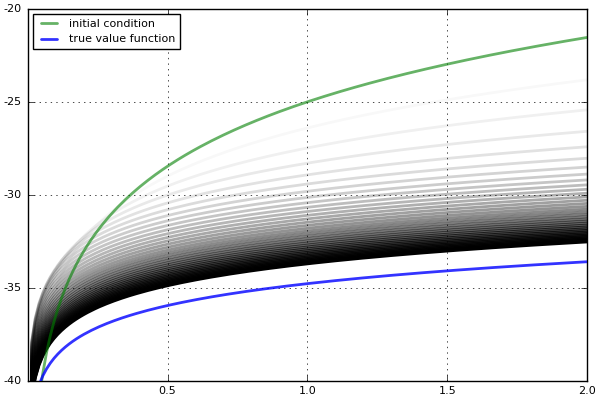

In [57]:
## Primitives and grid
alpha = 0.65
beta = 0.95
f(k) = k^alpha
u(c) = log(c)
grid_max = 2
grid_size = 150
grid = 1e-6:(grid_max-1e-6)/(grid_size-1):grid_max
gm = GrowthModel(f, beta, u, grid_max, grid_size) 

## Exact solution
ab = alpha * beta
c1 = (log(1 - ab) + log(ab) * ab / (1 - ab)) / (1 - beta)
c2 = alpha / (1 - ab)
v_star_func(k) = c1 .+ c2 .* log(k)

function main(n::Int=35)
    w_init = 5 .* log(grid) .- 25  # An initial condition -- fairly arbitrary
    w = copy(w_init)

    ws = []
    colors = []
    for i=1:n
        w = bellman_operator(gm, w)
        push!(ws, w)
        push!(colors, RGBA(0, 0, 0, i/n))
    end
    plot(grid, ws, color=colors', linewidth=2, label="")
    plot!(grid, w_init, color=:green, linewidth=2, alpha=0.6, label="initial condition")
    plot!(grid, v_star_func(grid), color=:blue, linewidth=2, alpha=0.8, label="true value function")
    plot!(ylims=(-40, -20), xlims=(minimum(grid), maximum(grid)))
end

main()


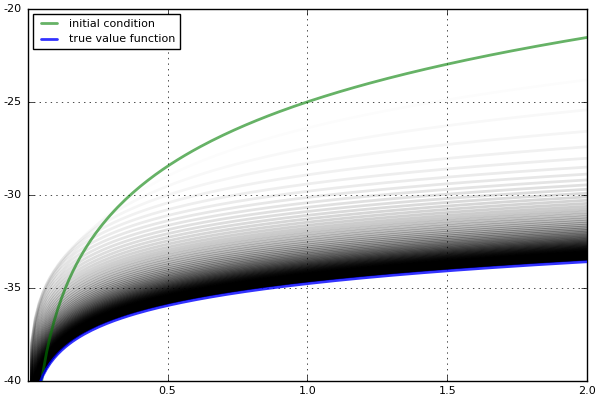

In [58]:
main(75)

## Exercise1


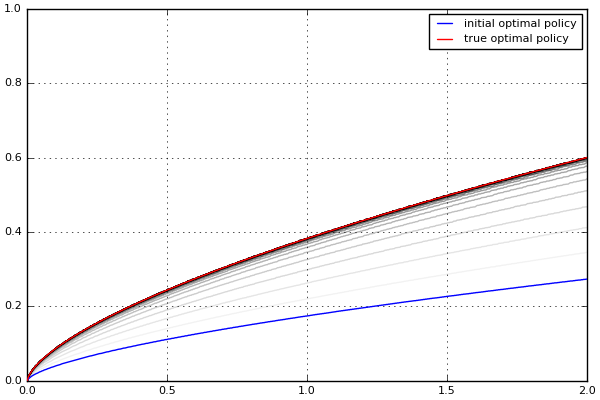

In [54]:
# setting Growth Model
alpha, beta = 0.65, 0.95
grid_max = 2
grid_size = 500
f(k) = k^alpha
u(c) = log(c)
gm = GrowthModel(f, beta, u, grid_max, grid_size) 

# true policy
true_sigma = (1 - alpha * beta) .* collect(gm.grid).^alpha

# initial policy
w = 5 .* gm.u(collect(gm.grid)) .- 25  # Initial guess of value function
sigma = get_greedy(gm, w) # initial guess of policy function

# definition of bellman operator
bellman(w) = bellman_operator(gm, w)

# now for n=1, 2, ..., 10 compute the policy after n VFI iterations
vf_n = []
colors = []
for n in 1:20
    v_star = compute_fixed_point(bellman, w, max_iter=n, verbose=false)
    push!(vf_n, get_greedy(gm, v_star))
    push!(colors, RGBA(0, 0, 0, n/20))
end

# construct the plot with the initial condition above
plot(gm.grid, vf_n, color=colors', label="")
plot!(gm.grid, sigma, color="blue", label="initial optimal policy")
plot!(gm.grid, true_sigma, color="red", label="true optimal policy", xlim=(0, 2), ylim=(0, 1))

## Exercise2


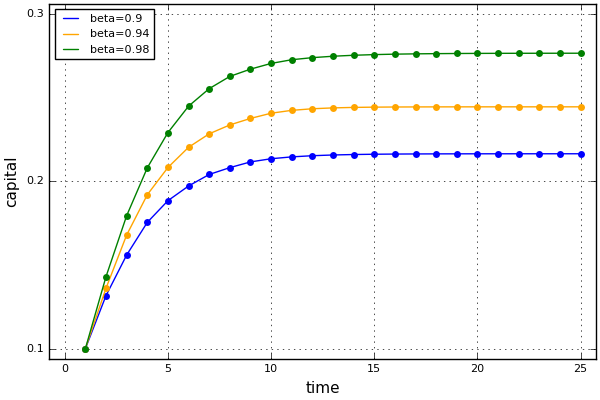

In [55]:
# setting Growth Model
alpha, beta = 0.65, 0.95
grid_max = 2
grid_size = 500
f(k) = k^alpha
u(c) = log(c)
gm = GrowthModel(f, beta, u, grid_max, grid_size) 

w = 5 .* gm.u(gm.grid) .- 25 # initial guess of value function
discount_factors = [0.9, 0.94, 0.98]
series_length = 25 # compute optimal capital stock from 1 to 25 period
xs = collect(1:25)
ks = []

for beta in discount_factors
    # Compute the optimal policy given the discount factor
    gm.beta = beta
    bellman(w) = bellman_operator(gm, w)
    v_s = compute_fixed_point(bellman, w, max_iter=500, verbose=false)
    sigma = get_greedy(gm, v_s) # optimal policy(points)
    
    # Next, compute the corresponding time series for capital
    k = Array(Float64, series_length)
    k[1] = 0.1 # initial capital
    sigma_func = LinearInterpolation.LinInterp(gm.grid, sigma) # sigma is points, so we have to interpolate to get optimal policy function
    
    for t=2:series_length
        k[t] = gm.f(k[t-1]) - sigma_func(k[t-1])
    end
    
    push!(ks, k)
end

# for loopの中に入れると上手く描画できないのでとりあえずこのまま
plot(xs, ks[1], color="blue", line=(:path, 1), markershape=:circle, markersize=5, markerstrokewidth=0, label="beta=0.9")
plot!(xs, ks[2], color="orange", line=(:path, 1), markershape=:circle, markersize=5, markerstrokewidth=0, label="beta=0.94")
plot!(xs, 
    ks[3], 
    color="green", 
    line=(:path, 1), 
    markershape=:circle, 
    markersize=5, 
    markerstrokewidth=0, 
    label="beta=0.98", 
    xlim=(0, 25), 
    ylim=(0.1, 0.3), 
    xlabel="time", 
    ylabel="capital",
    xticks = 0:5:25)